<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

from collections import OrderedDict
from math import isclose
import zipfile 
from urllib.request import urlopen
import io

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot


# For details about the data cleanup, please see 
# https://github.com/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/CleanupOnlineNewsPopularity.ipynb
# and 'The Dataset' section of
# https://nsriniva.github.io/2020-10-23-DSPT9-Unit1-BuildProject/

# Cleaned up and uploaded csv data file from 
# https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip 
# in
# https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity
# to my github repo as
# https://github.com/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/OnlineNewsPopularity.csv.zip?raw=true

# The associated names file is available at
# https://raw.githubusercontent.com/nsriniva/DS-Unit-2-Applied-Modeling/master/OnlineNewsPopularity.names


onp_url = 'https://github.com/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/OnlineNewsPopularity.csv.zip?raw=true'

onp_df = pd.read_csv(onp_url, compression='zip')

null_values = onp_df.isna().sum().sum()

print(f"There are {['','no'][int(null_values==0)]} invalid values in the dataset!")

# The zscore() method from the scipy.stats package is used to compute z scores 
# for the shares values. These z scores is compared against the specified  
# sigma value to generate a boolean filter array that could be used to 
# paritition the dataset based on whether the zscore is greater than the
# specified sigma.
def get_sigma_filter(df, sigma=0.5):
  z = np.abs(stats.zscore(df.shares))
  return np.where(z>sigma)[0]

# Use the boolean filter array provided by get_sigma_filter() to
# ignore entries with zscore greater than 0.5 and compute the
# median and max 'shares' values for the remaining entries.
def classification_marks(df):

  shares_info = df.drop(get_sigma_filter(df)).shares

  max = shares_info.max()
  median = shares_info.median()

  return median, max


shares_median = onp_df.shares.median()

print(shares_median)
# Use the medium(median) value to classify articles into 
# unpopular(0) and popular(1)  
onp_df['popularity'] = onp_df.shares.apply(lambda x: 0 if x < shares_median else 1)

display(onp_df.shape)

# Remove outliers
def remove_outliers(df, sigma=0.5):
  df = df.copy()
  return df.drop(get_sigma_filter(df, sigma))


onp_no_df = onp_df.copy()

#onp_no_df = remove_outliers(onp_no_df, 0.25)

shares_median = onp_no_df.shares.median()

print(shares_median)

# Use the medium(median) value to classify articles into 
# unpopular(0) and popular(1)  
onp_no_df['popularity'] = onp_no_df.shares.apply(lambda x: 0 if x < shares_median else 1)

display(onp_no_df.shape)



# The baseline accuracy or the value we'd get by just guessing that that the
# value is always the majority class

target = 'popularity'

baseline_accuracy = onp_no_df[target].value_counts(normalize=True).max()

print(f'baseline_accuracy = {baseline_accuracy:0.4f}')

# Drop the 'shares' column used to derive 'popularity' along
# with the non predictive 'url' and 'timedelta' columns.
drop_cols = ['shares', 'url', 'timedelta']

onp_no_df = onp_no_df.drop(columns=drop_cols)
# Will use a random split of 64% Training, 16% Validation and 20% Test 

X = onp_no_df.drop(columns=target)
y = onp_no_df[target]

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,train_size=0.8, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=42)

display(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

display(y_train.value_counts(normalize=True))
baseline_accuracy = y_train.value_counts(normalize=True).max()

print(f'baseline_accuracy = {baseline_accuracy:0.4f}')

# Simple model, with OrdinalEncoder for the data_channel and weekday categorical
# columns and a DecisionTreeClassifier with default parameter values.
model = make_pipeline(
  OrdinalEncoder(), 
  DecisionTreeClassifier()
)

model.fit(X_train, y_train)

display(y_train.value_counts(normalize=True))
display(y_val.value_counts(normalize=True))

training_bl = y_train.value_counts(normalize=True).max()
validation_bl = y_val.value_counts(normalize=True).max()

training_acc =  model.score(X_train, y_train)
validation_acc =  model.score(X_val, y_val)


print(f'Training Accuracy:{training_acc:0.4f}/{training_bl:0.4f}')
print(f'Validation Accuracy:{validation_acc:0.4f}/{validation_bl:0.4f}')

transformers = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=103, random_state=42, n_jobs=-1, max_depth=25, min_samples_leaf=3, max_features=0.3)
model.fit(X_train_transformed, y_train)


permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)







In [2]:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)


Weight,Feature
0.0207 ± 0.0071,kw_avg_avg
0.0191 ± 0.0063,is_weekend
0.0091 ± 0.0041,self_reference_min_shares
0.0085 ± 0.0022,data_channel
0.0057 ± 0.0028,kw_max_avg
0.0051 ± 0.0012,LDA_01
0.0050 ± 0.0026,LDA_04
0.0034 ± 0.0024,kw_avg_min
0.0032 ± 0.0019,n_tokens_content
0.0025 ± 0.0022,kw_min_avg


In [3]:
print('Shape before removing', X_train.shape)

minimum_importance = 0 
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

print('Shape after removing ', X_train.shape)

X_val = X_val[features]
X_test = X_test[features]


Shape before removing (25372, 47)
Shape after removing  (25372, 29)


In [4]:
model = make_pipeline(
  OrdinalEncoder(), 
  DecisionTreeClassifier(max_depth=7,random_state=42, min_samples_leaf=3)
)

model.fit(X_train, y_train)

display(y_train.value_counts(normalize=True))
display(y_val.value_counts(normalize=True))

training_bl = y_train.value_counts(normalize=True).max()
validation_bl = y_val.value_counts(normalize=True).max()

training_acc =  model.score(X_train, y_train)
validation_acc =  model.score(X_val, y_val)


print(f'Training Accuracy:{training_acc:0.4f}/{training_bl:0.4f}')
print(f'Validation Accuracy:{validation_acc:0.4f}/{validation_bl:0.4f}')

1    0.536891
0    0.463109
Name: popularity, dtype: float64

1    0.532398
0    0.467602
Name: popularity, dtype: float64

Training Accuracy:0.6688/0.5369
Validation Accuracy:0.6413/0.5324


In [5]:
pipe_elems = (
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=103, random_state=42, n_jobs=-1, max_depth=25, min_samples_leaf=3, max_features=0.3)
)

pipe = make_pipeline(
  *pipe_elems
)


# Fit on train, score on val
pipe.fit(X_train, y_train)
print('Validation Accuracy', pipe.score(X_val, y_val))
print('Test Accuracy', pipe.score(X_test, y_test))

Validation Accuracy 0.6697146460665301
Test Accuracy 0.6616218943120191


In [6]:

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model = XGBClassifier(n_estimators=1000, random_state=42, n_jobs=-1, max_depth=6, learning_rate=0.5) 

eval_metric = 'error'
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric=eval_metric,
          early_stopping_rounds=500)
          

y_pred = model.predict(X_val_encoded)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

[0]	validation_0-error:0.343844	validation_1-error:0.361974
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 500 rounds.
[1]	validation_0-error:0.331113	validation_1-error:0.360713
[2]	validation_0-error:0.319131	validation_1-error:0.353776
[3]	validation_0-error:0.312234	validation_1-error:0.347627
[4]	validation_0-error:0.303169	validation_1-error:0.344632
[5]	validation_0-error:0.298912	validation_1-error:0.342109
[6]	validation_0-error:0.294971	validation_1-error:0.335173
[7]	validation_0-error:0.290793	validation_1-error:0.334542
[8]	validation_0-error:0.286221	validation_1-error:0.335173
[9]	validation_0-error:0.282831	validation_1-error:0.337064
[10]	validation_0-error:0.279639	validation_1-error:0.337537
[11]	validation_0-error:0.274358	validation_1-error:0.339587
[12]	validation_0-error:0.269983	validation_1-error:0.338483
[13]	validation_0-error:0.266908	validation_1-error:0.3

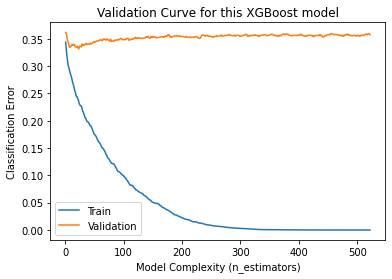

In [7]:
results = model.evals_result()
train_error = results['validation_0'][eval_metric]
val_error = results['validation_1'][eval_metric]
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel(f'Classification {eval_metric.capitalize()}')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
#plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();

In [8]:

class_index = 1
y_pred_proba = model.predict_proba(X_test_encoded)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.7076693916256456


In [9]:

features = ['is_weekend', 'kw_avg_avg']

print(X_train_encoded.shape, X_val_encoded.shape)

isolated = []

for feature in features:
  isolated.append(
      pdp_isolate(
      model=model, 
      dataset=X_val_encoded, 
      model_features=X_val_encoded.columns, 
      feature=feature
    )
  )

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns,
    features=features
)



(25372, 29) (6343, 29)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


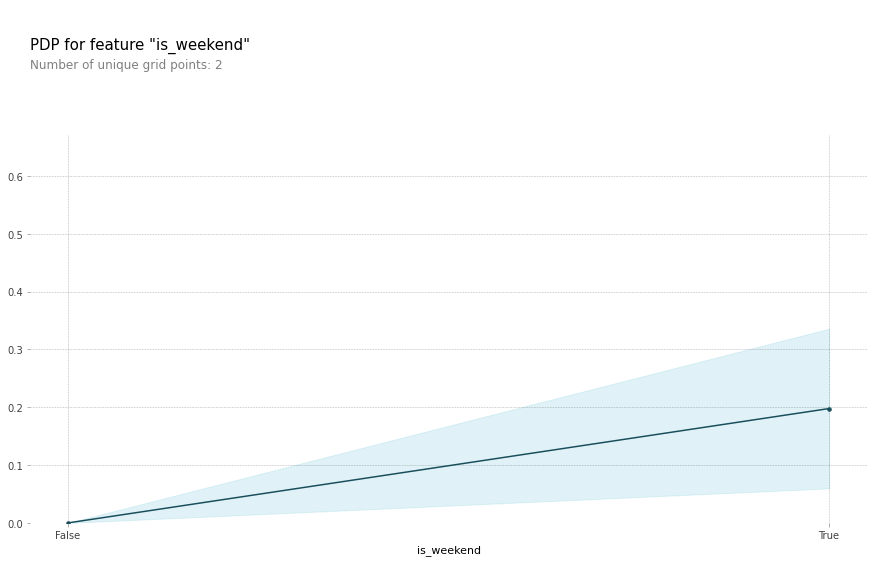

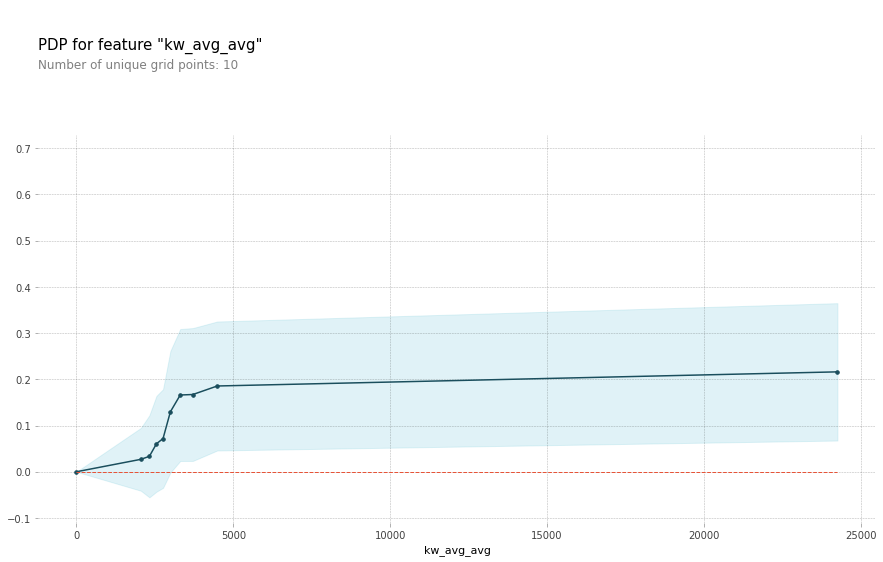

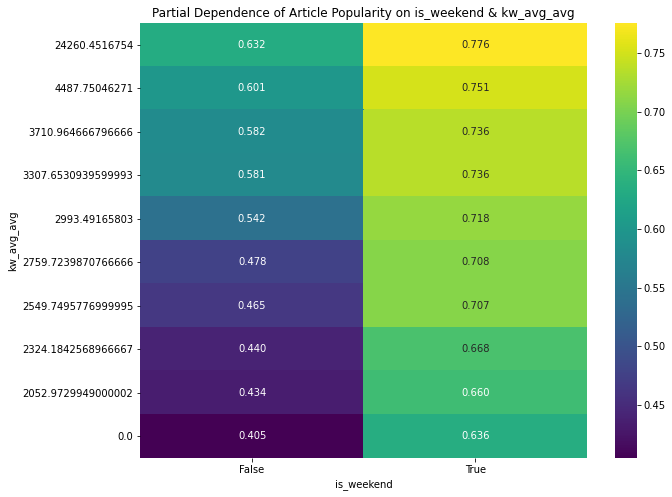

In [10]:
for idx,elem in enumerate(isolated):
  pdp_plot(elem, feature_name=features[idx]);
  if features[idx] == 'is_weekend':
    # Manually change the xticks labels
    plt.xticks([0, 1], ['False', 'True']);

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns={0:'False', 1:'True'})
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.3f', cmap='viridis')
plt.title('Partial Dependence of Article Popularity on is_weekend & kw_avg_avg');


In [11]:
display(X_test_encoded.head())

row = X_test_encoded.loc[[198]]

row

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_keywords,kw_max_min,kw_avg_min,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,is_weekend,LDA_01,LDA_02,LDA_04,avg_positive_polarity,max_positive_polarity,avg_negative_polarity,title_sentiment_polarity,abs_title_subjectivity,data_channel,weekday
32340,12.0,1015.0,0.422018,1.0,0.545031,10.0,33.0,4.0,263.0,110.500000,843300.0,398350.000000,1809.075,3483.806797,2729.047648,1100.0,22100.0,6475.0,0.0,0.050050,0.050035,0.518333,0.333534,0.8,-0.160714,0.00,0.5,7,7
10480,9.0,503.0,0.569697,1.0,0.737542,9.0,1.0,10.0,3200.0,524.750000,843300.0,117960.000000,0.000,4228.114286,2387.526307,0.0,0.0,0.0,0.0,0.020008,0.325602,0.614379,0.419786,1.0,-0.157500,0.00,0.5,3,6
15370,9.0,232.0,0.646018,1.0,0.748428,12.0,4.0,6.0,939.0,198.666667,843300.0,573878.333333,954.500,6192.239067,4385.022237,1400.0,58800.0,30100.0,0.0,0.033697,0.033333,0.033333,0.468750,0.5,-0.427500,0.00,0.5,5,2
31592,12.0,171.0,0.722892,1.0,0.867925,9.0,0.0,6.0,2100.0,444.166667,843300.0,311033.333333,2076.520,4529.427500,3269.856640,974.0,5600.0,2574.8,0.0,0.033335,0.033334,0.033822,0.500000,0.5,-0.216667,-0.25,0.1,7,2
198,11.0,286.0,0.652632,1.0,0.800000,5.0,0.0,8.0,552.0,356.200000,28000.0,6830.125000,0.000,2240.536313,976.913444,822.0,822.0,822.0,0.0,0.025062,0.025016,0.710028,0.303429,0.6,-0.251786,-0.10,0.3,3,6


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_keywords,kw_max_min,kw_avg_min,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,is_weekend,LDA_01,LDA_02,LDA_04,avg_positive_polarity,max_positive_polarity,avg_negative_polarity,title_sentiment_polarity,abs_title_subjectivity,data_channel,weekday
198,11.0,286.0,0.652632,1.0,0.8,5.0,0.0,8.0,552.0,356.2,28000.0,6830.125,0.0,2240.536313,976.913444,822.0,822.0,822.0,0.0,0.025062,0.025016,0.710028,0.303429,0.6,-0.251786,-0.1,0.3,3,6


In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row,
    #matplotlib=True, # This does not work if link is set to 'logit'
    link='logit' # For classification, this shows predicted probabilities
)